# Lotka Volterra UPINN

In [ ]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pysindy as ps
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from UPINN import UPINN
from DataGenerators import sample_collocation_points
from Architectures import FNN, ResNet
from LotkaVolterraData import LotkaVolterraData
from Utils import SINDy_sklearn

Consider the Lotka-Volterra equations, which describe the dynamics of a predator-prey system:

\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= - \delta y + \gamma x y,
\end{align}

where $x$ is the number of prey, $y$ is the number of predators, and $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants.

## Generate Data from System

In [67]:
time_int = [0, 20]

In [68]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = torch.tensor([1.0, 1.0]).reshape(-1, 2)

In [69]:
# Collocation points
N_coll = 1000
Xc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

### Known system $N_K$

Assume that $\gamma x y$ is not known, and we want to learn it from data.

In [ ]:
class LV(torch.nn.Module):
    
    def __init__(self, params):
        super(LV, self).__init__()
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.delta = params['delta']
        self.gamma = params['gamma']

    def forward(self, z, U):

        dUdt = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        return torch.stack([
            dUdt[:, 0] - alpha*U[:, 0] + beta*U[:, 0]*U[:, 1],
            dUdt[:, 1] + delta*U[:, 1] - gamma*U[:, 0]*U[:, 1]
        ], dim=-1)

alpha, beta, gamma, delta = 2/3, 4/3, 1.0, 1.0
params = dict(
    alpha=alpha,
    beta=beta,
    delta=delta,
    gamma=gamma
)

data = LVData(Xbc, alpha, beta, gamma, delta, time_int)

N = LV(params)

### Problem specific UPINN functions

In [ ]:
class LV_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.nn.MSELoss()(u_pred, data.X_full)
    

    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            t_plot = data.t_full
            x_true = data.X_full[:, 0:1]
            y_true = data.X_full[:, 1:2]

            u_pred = self.u(t_plot)
            
            x_pred = u_pred[:, 0]
            y_pred = u_pred[:, 1]

            plt.plot(t_plot, x_pred, 'r', label='Predator')
            plt.plot(t_plot, y_pred, 'b', label='Prey')
            plt.plot(t_plot, x_true, 'r--')
            plt.plot(t_plot, y_true, 'b--')
            plt.xlabel('t')
            plt.legend()

            if save is not None:
                plt.savefig(save+'pdf', format='pdf', bbox_inches='tight')

            plt.show()


### Setup UPINN

In [ ]:
# Define model architectures
hidden = [16] * 4
u = FNN(
    dims=[1, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.SiLU(),
)

In [73]:
upinn = LV_UPINN(u, N, boundary_points=(tbc, Xbc), collocation_points=Xc)

[Info]: Initializing PINN model (Residual network F unspecified; Setting F to 0.0)


### Train

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.23 epoch/s, loss=1.25e-04, bc_loss=1.58e-07, data_loss=0.00e+00, pde_loss=1.25e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.34 epoch/s, loss=4.53e-05, bc_loss=2.62e-08, data_loss=0.00e+00, pde_loss=4.53e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.40 epoch/s, loss=3.13e-05, bc_loss=1.33e-08, data_loss=0.00e+00, pde_loss=3.13e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 75.43 epoch/s, loss=2.19e-05, bc_loss=7.00e-09, data_loss=0.00e+00, pde_loss=2.19e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 73.65 epoch/s, loss=1.55e-05, bc_loss=3.18e-09, data_loss=0.00e+00, pde_loss=1.55e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 76.66 epoch/s, loss=1.11e-05, bc_loss=1.98e-09, data_loss=0.00e+00, pde_loss=1.11e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 72.87 epoch/s, loss=8.08e-06, bc_loss=8.97e-10, data_loss=0.00e+00, pde_loss=8.08e-06]


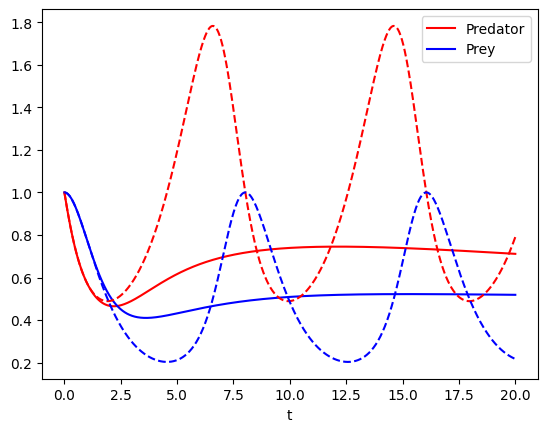

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.64 epoch/s, loss=8.26e-06, bc_loss=1.75e-09, data_loss=0.00e+00, pde_loss=8.26e-06]


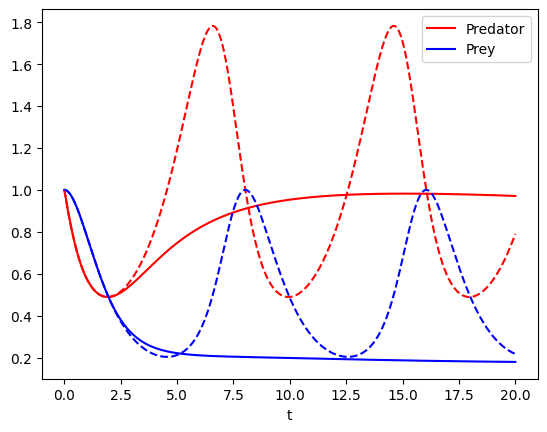

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.49 epoch/s, loss=8.90e-06, bc_loss=2.82e-10, data_loss=0.00e+00, pde_loss=8.90e-06]


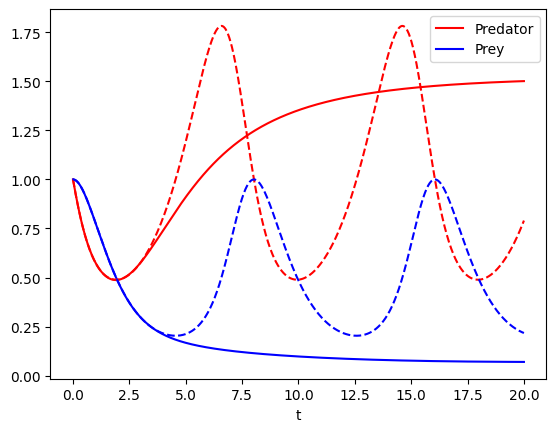

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 83.05 epoch/s, loss=2.38e-05, bc_loss=5.50e-09, data_loss=0.00e+00, pde_loss=2.38e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.89 epoch/s, loss=1.61e-05, bc_loss=5.18e-07, data_loss=0.00e+00, pde_loss=1.56e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.02 epoch/s, loss=8.08e-06, bc_loss=8.00e-08, data_loss=0.00e+00, pde_loss=8.00e-06]


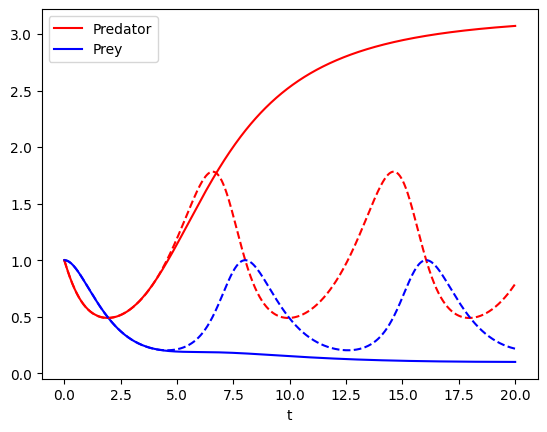

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 92.57 epoch/s, loss=2.26e-05, bc_loss=1.32e-08, data_loss=0.00e+00, pde_loss=2.26e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 92.72 epoch/s, loss=1.34e-05, bc_loss=4.79e-09, data_loss=0.00e+00, pde_loss=1.34e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.96 epoch/s, loss=1.17e-05, bc_loss=7.05e-07, data_loss=0.00e+00, pde_loss=1.09e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.13 epoch/s, loss=6.22e-05, bc_loss=2.52e-05, data_loss=0.00e+00, pde_loss=3.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 83.87 epoch/s, loss=1.58e-05, bc_loss=5.07e-06, data_loss=0.00e+00, pde_loss=1.08e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.80 epoch/s, loss=5.74e-06, bc_loss=4.13e-07, data_loss=0.00e+00, pde_loss=5.33e-06]


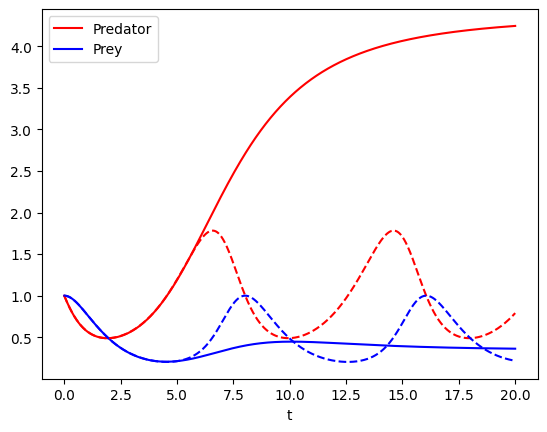

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 91.04 epoch/s, loss=1.39e-04, bc_loss=4.02e-07, data_loss=0.00e+00, pde_loss=1.39e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 92.62 epoch/s, loss=1.21e-04, bc_loss=3.14e-07, data_loss=0.00e+00, pde_loss=1.21e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 90.37 epoch/s, loss=9.74e-05, bc_loss=3.73e-07, data_loss=0.00e+00, pde_loss=9.70e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.40 epoch/s, loss=7.79e-05, bc_loss=5.46e-07, data_loss=0.00e+00, pde_loss=7.74e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 86.97 epoch/s, loss=4.68e-05, bc_loss=1.22e-07, data_loss=0.00e+00, pde_loss=4.67e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 85.85 epoch/s, loss=4.11e-05, bc_loss=6.20e-06, data_loss=0.00e+00, pde_loss=3.49e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.98 epoch/s, loss=2.67e-05, bc_loss=5.76e-07, data_loss=0.00e+00, pde_loss=2.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 78.20 epoch/s, loss=2.29e-05, bc_loss=2.57e-06, data_loss=0.00e+00, pde_loss=2.03e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 76.51 epoch/s, loss=1.95e-05, bc_loss=3.01e-06, data_loss=0.00e+00, pde_loss=1.65e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 73.28 epoch/s, loss=1.56e-05, bc_loss=2.95e-07, data_loss=0.00e+00, pde_loss=1.53e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 63.55 epoch/s, loss=1.51e-05, bc_loss=7.14e-07, data_loss=0.00e+00, pde_loss=1.44e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 63.55 epoch/s, loss=1.20e-05, bc_loss=5.40e-07, data_loss=0.00e+00, pde_loss=1.14e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 67.85 epoch/s, loss=6.90e-06, bc_loss=3.61e-08, data_loss=0.00e+00, pde_loss=6.86e-06]


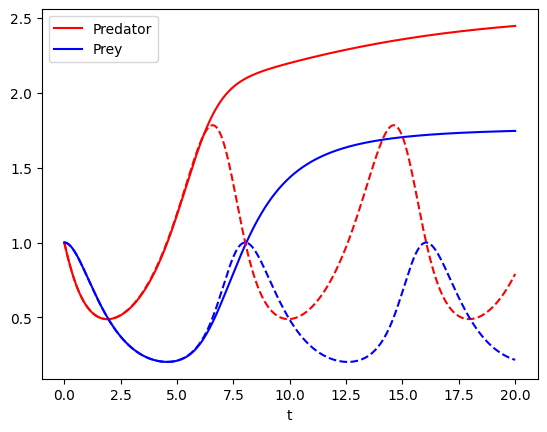

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 90.46 epoch/s, loss=3.13e-04, bc_loss=5.48e-07, data_loss=0.00e+00, pde_loss=3.12e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 87.85 epoch/s, loss=1.97e-04, bc_loss=2.35e-07, data_loss=0.00e+00, pde_loss=1.96e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 85.70 epoch/s, loss=9.20e-05, bc_loss=7.43e-08, data_loss=0.00e+00, pde_loss=9.19e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 84.74 epoch/s, loss=3.67e-05, bc_loss=3.52e-06, data_loss=0.00e+00, pde_loss=3.32e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.11 epoch/s, loss=7.87e-06, bc_loss=3.11e-09, data_loss=0.00e+00, pde_loss=7.87e-06]


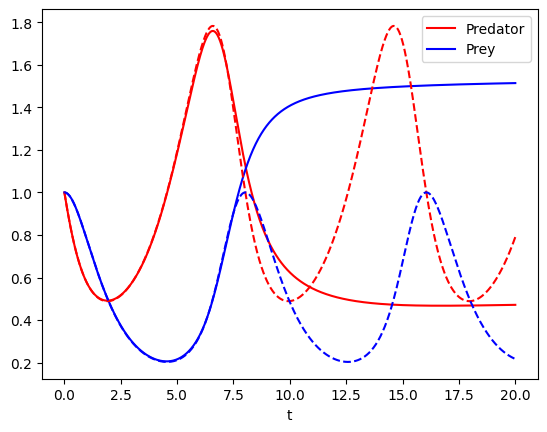

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.62 epoch/s, loss=9.62e-05, bc_loss=9.77e-08, data_loss=0.00e+00, pde_loss=9.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 85.59 epoch/s, loss=4.90e-05, bc_loss=3.03e-08, data_loss=0.00e+00, pde_loss=4.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.11 epoch/s, loss=2.48e-05, bc_loss=9.36e-07, data_loss=0.00e+00, pde_loss=2.38e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 84.62 epoch/s, loss=1.29e-05, bc_loss=3.18e-09, data_loss=0.00e+00, pde_loss=1.29e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 83.15 epoch/s, loss=5.54e-05, bc_loss=2.93e-06, data_loss=0.00e+00, pde_loss=5.25e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 83.45 epoch/s, loss=5.42e-06, bc_loss=3.28e-08, data_loss=0.00e+00, pde_loss=5.38e-06]


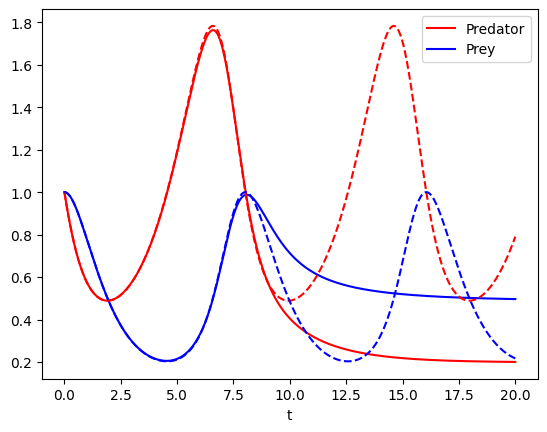

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 90.47 epoch/s, loss=5.03e-06, bc_loss=5.12e-09, data_loss=0.00e+00, pde_loss=5.03e-06]


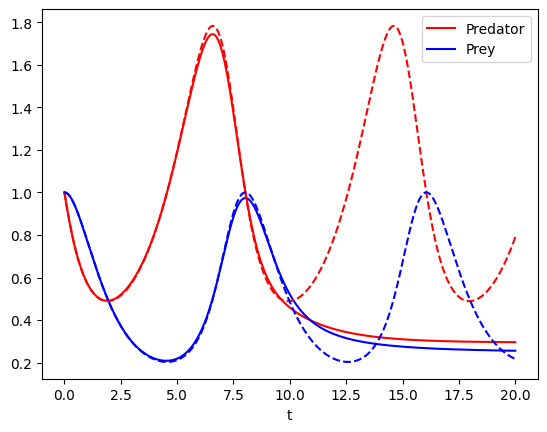

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.41 epoch/s, loss=2.06e-05, bc_loss=3.69e-08, data_loss=0.00e+00, pde_loss=2.06e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.26 epoch/s, loss=1.76e-05, bc_loss=7.58e-07, data_loss=0.00e+00, pde_loss=1.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 87.17 epoch/s, loss=3.47e-05, bc_loss=3.35e-06, data_loss=0.00e+00, pde_loss=3.13e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 86.76 epoch/s, loss=6.16e-06, bc_loss=3.50e-08, data_loss=0.00e+00, pde_loss=6.12e-06]


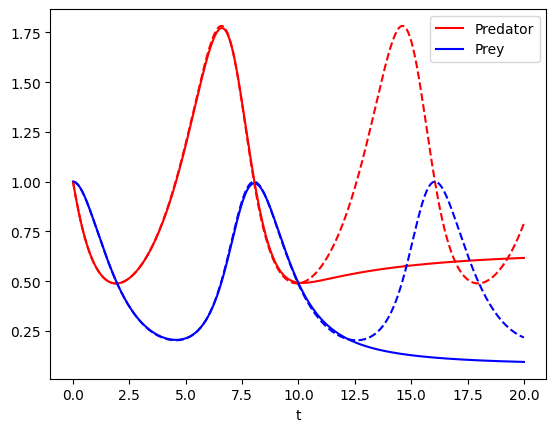

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.17 epoch/s, loss=4.91e-05, bc_loss=3.53e-08, data_loss=0.00e+00, pde_loss=4.91e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.62 epoch/s, loss=9.50e-05, bc_loss=2.98e-06, data_loss=0.00e+00, pde_loss=9.20e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.27 epoch/s, loss=2.68e-05, bc_loss=4.59e-06, data_loss=0.00e+00, pde_loss=2.22e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 86.60 epoch/s, loss=1.90e-05, bc_loss=5.30e-07, data_loss=0.00e+00, pde_loss=1.84e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 74.41 epoch/s, loss=1.31e-05, bc_loss=6.60e-09, data_loss=0.00e+00, pde_loss=1.31e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 71.80 epoch/s, loss=1.11e-05, bc_loss=2.08e-07, data_loss=0.00e+00, pde_loss=1.09e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 69.24 epoch/s, loss=8.83e-06, bc_loss=1.25e-09, data_loss=0.00e+00, pde_loss=8.83e-06]


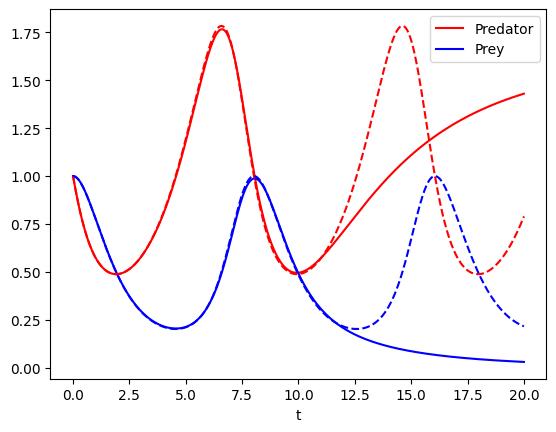

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.25 epoch/s, loss=4.89e-05, bc_loss=3.94e-08, data_loss=0.00e+00, pde_loss=4.88e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 84.79 epoch/s, loss=2.84e-05, bc_loss=3.80e-08, data_loss=0.00e+00, pde_loss=2.83e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 85.49 epoch/s, loss=1.03e-04, bc_loss=3.63e-06, data_loss=0.00e+00, pde_loss=9.91e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.09 epoch/s, loss=1.37e-05, bc_loss=2.17e-07, data_loss=0.00e+00, pde_loss=1.35e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.06 epoch/s, loss=1.08e-05, bc_loss=3.19e-08, data_loss=0.00e+00, pde_loss=1.08e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 75.06 epoch/s, loss=7.78e-06, bc_loss=7.84e-10, data_loss=0.00e+00, pde_loss=7.78e-06]


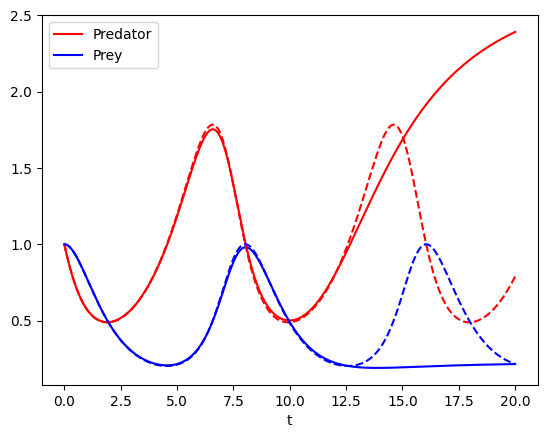

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.87 epoch/s, loss=3.03e-05, bc_loss=2.47e-08, data_loss=0.00e+00, pde_loss=3.03e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.48 epoch/s, loss=1.86e-05, bc_loss=8.94e-09, data_loss=0.00e+00, pde_loss=1.86e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 84.63 epoch/s, loss=1.21e-05, bc_loss=4.33e-09, data_loss=0.00e+00, pde_loss=1.21e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 78.39 epoch/s, loss=8.13e-06, bc_loss=4.26e-08, data_loss=0.00e+00, pde_loss=8.09e-06]


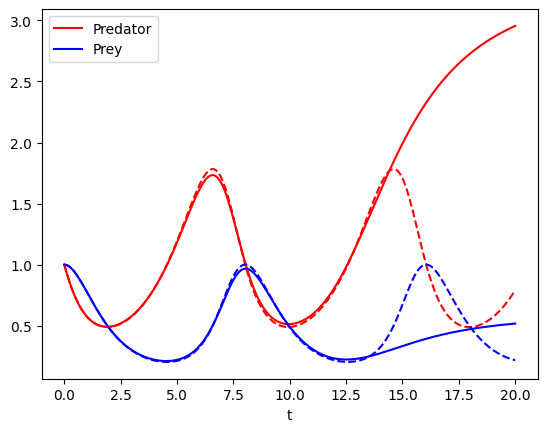

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.91 epoch/s, loss=5.36e-05, bc_loss=1.67e-06, data_loss=0.00e+00, pde_loss=5.19e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 86.02 epoch/s, loss=4.51e-05, bc_loss=4.20e-08, data_loss=0.00e+00, pde_loss=4.51e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.71 epoch/s, loss=4.13e-05, bc_loss=6.34e-07, data_loss=0.00e+00, pde_loss=4.06e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 78.12 epoch/s, loss=3.63e-05, bc_loss=1.08e-06, data_loss=0.00e+00, pde_loss=3.52e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.15 epoch/s, loss=3.25e-05, bc_loss=3.64e-08, data_loss=0.00e+00, pde_loss=3.25e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.07 epoch/s, loss=3.12e-05, bc_loss=1.38e-07, data_loss=0.00e+00, pde_loss=3.11e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 75.05 epoch/s, loss=3.08e-05, bc_loss=8.24e-07, data_loss=0.00e+00, pde_loss=2.99e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.46 epoch/s, loss=2.86e-05, bc_loss=1.80e-07, data_loss=0.00e+00, pde_loss=2.84e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.95 epoch/s, loss=2.98e-05, bc_loss=2.23e-06, data_loss=0.00e+00, pde_loss=2.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.61 epoch/s, loss=5.99e-05, bc_loss=4.19e-06, data_loss=0.00e+00, pde_loss=5.57e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 67.47 epoch/s, loss=1.23e-04, bc_loss=8.17e-05, data_loss=0.00e+00, pde_loss=4.11e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 76.69 epoch/s, loss=4.42e-05, bc_loss=1.24e-06, data_loss=0.00e+00, pde_loss=4.30e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 75.63 epoch/s, loss=2.50e-05, bc_loss=1.44e-08, data_loss=0.00e+00, pde_loss=2.49e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 72.90 epoch/s, loss=2.44e-05, bc_loss=1.47e-08, data_loss=0.00e+00, pde_loss=2.44e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 74.56 epoch/s, loss=2.39e-05, bc_loss=2.40e-08, data_loss=0.00e+00, pde_loss=2.38e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 73.10 epoch/s, loss=2.34e-05, bc_loss=2.40e-08, data_loss=0.00e+00, pde_loss=2.33e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 72.29 epoch/s, loss=3.44e-05, bc_loss=4.06e-07, data_loss=0.00e+00, pde_loss=3.40e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 71.02 epoch/s, loss=3.57e-05, bc_loss=5.63e-06, data_loss=0.00e+00, pde_loss=3.01e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 70.71 epoch/s, loss=2.25e-05, bc_loss=3.29e-07, data_loss=0.00e+00, pde_loss=2.22e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 69.26 epoch/s, loss=1.63e-04, bc_loss=1.21e-04, data_loss=0.00e+00, pde_loss=4.18e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.33 epoch/s, loss=2.10e-05, bc_loss=2.10e-08, data_loss=0.00e+00, pde_loss=2.10e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 67.00 epoch/s, loss=8.99e-05, bc_loss=4.39e-06, data_loss=0.00e+00, pde_loss=8.56e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.38 epoch/s, loss=2.02e-05, bc_loss=2.13e-08, data_loss=0.00e+00, pde_loss=2.02e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 65.54 epoch/s, loss=7.83e-05, bc_loss=4.91e-05, data_loss=0.00e+00, pde_loss=2.92e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 64.95 epoch/s, loss=2.25e-05, bc_loss=1.12e-07, data_loss=0.00e+00, pde_loss=2.24e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 64.19 epoch/s, loss=2.00e-05, bc_loss=7.09e-07, data_loss=0.00e+00, pde_loss=1.93e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 63.73 epoch/s, loss=2.20e-05, bc_loss=4.41e-07, data_loss=0.00e+00, pde_loss=2.16e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 61.99 epoch/s, loss=1.81e-05, bc_loss=1.57e-08, data_loss=0.00e+00, pde_loss=1.81e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 60.30 epoch/s, loss=1.77e-05, bc_loss=1.66e-08, data_loss=0.00e+00, pde_loss=1.77e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 59.25 epoch/s, loss=3.68e-05, bc_loss=1.57e-06, data_loss=0.00e+00, pde_loss=3.52e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 59.38 epoch/s, loss=1.70e-05, bc_loss=2.24e-07, data_loss=0.00e+00, pde_loss=1.68e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 59.67 epoch/s, loss=1.64e-05, bc_loss=1.29e-08, data_loss=0.00e+00, pde_loss=1.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 59.09 epoch/s, loss=1.63e-05, bc_loss=4.12e-07, data_loss=0.00e+00, pde_loss=1.59e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 58.63 epoch/s, loss=1.76e-05, bc_loss=1.48e-06, data_loss=0.00e+00, pde_loss=1.61e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 58.16 epoch/s, loss=1.84e-05, bc_loss=3.02e-06, data_loss=0.00e+00, pde_loss=1.54e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:10<00:00, 48.52 epoch/s, loss=1.46e-05, bc_loss=1.25e-08, data_loss=0.00e+00, pde_loss=1.46e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 53.70 epoch/s, loss=1.98e-05, bc_loss=5.98e-07, data_loss=0.00e+00, pde_loss=1.92e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 52.99 epoch/s, loss=1.40e-05, bc_loss=3.45e-07, data_loss=0.00e+00, pde_loss=1.37e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 51.84 epoch/s, loss=1.42e-05, bc_loss=2.91e-07, data_loss=0.00e+00, pde_loss=1.39e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 55.71 epoch/s, loss=1.27e-05, bc_loss=8.76e-09, data_loss=0.00e+00, pde_loss=1.27e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 50.91 epoch/s, loss=1.68e-05, bc_loss=3.44e-06, data_loss=0.00e+00, pde_loss=1.34e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 54.71 epoch/s, loss=1.68e-05, bc_loss=2.28e-06, data_loss=0.00e+00, pde_loss=1.46e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 53.59 epoch/s, loss=4.32e-05, bc_loss=2.70e-05, data_loss=0.00e+00, pde_loss=1.62e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 53.67 epoch/s, loss=1.93e-05, bc_loss=7.18e-06, data_loss=0.00e+00, pde_loss=1.21e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 53.00 epoch/s, loss=1.07e-05, bc_loss=8.99e-08, data_loss=0.00e+00, pde_loss=1.06e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:09<00:00, 52.22 epoch/s, loss=9.93e-06, bc_loss=2.39e-08, data_loss=0.00e+00, pde_loss=9.91e-06]


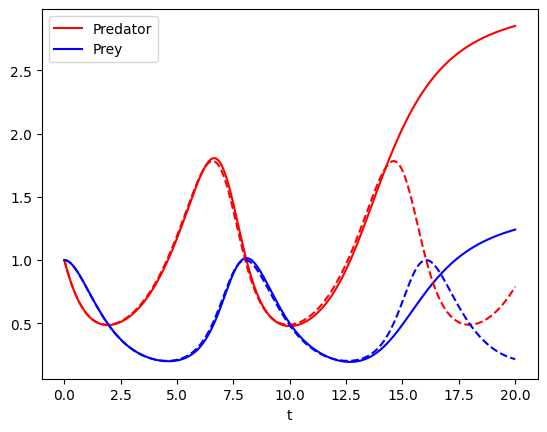

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 91.93 epoch/s, loss=1.58e-04, bc_loss=5.14e-07, data_loss=0.00e+00, pde_loss=1.58e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 90.55 epoch/s, loss=1.48e-04, bc_loss=2.64e-07, data_loss=0.00e+00, pde_loss=1.48e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.62 epoch/s, loss=1.58e-04, bc_loss=1.88e-05, data_loss=0.00e+00, pde_loss=1.39e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 86.44 epoch/s, loss=1.31e-04, bc_loss=1.41e-07, data_loss=0.00e+00, pde_loss=1.31e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.55 epoch/s, loss=1.20e-04, bc_loss=1.33e-07, data_loss=0.00e+00, pde_loss=1.20e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.77 epoch/s, loss=1.11e-04, bc_loss=4.67e-08, data_loss=0.00e+00, pde_loss=1.11e-04]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 83.71 epoch/s, loss=9.85e-05, bc_loss=4.71e-08, data_loss=0.00e+00, pde_loss=9.85e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 83.21 epoch/s, loss=8.66e-05, bc_loss=2.23e-07, data_loss=0.00e+00, pde_loss=8.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.88 epoch/s, loss=8.26e-05, bc_loss=7.68e-06, data_loss=0.00e+00, pde_loss=7.49e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.60 epoch/s, loss=6.50e-05, bc_loss=1.12e-06, data_loss=0.00e+00, pde_loss=6.39e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.97 epoch/s, loss=5.05e-05, bc_loss=3.66e-07, data_loss=0.00e+00, pde_loss=5.01e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 77.62 epoch/s, loss=1.50e-05, bc_loss=1.13e-07, data_loss=0.00e+00, pde_loss=1.49e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 75.16 epoch/s, loss=4.27e-06, bc_loss=4.91e-09, data_loss=0.00e+00, pde_loss=4.26e-06]


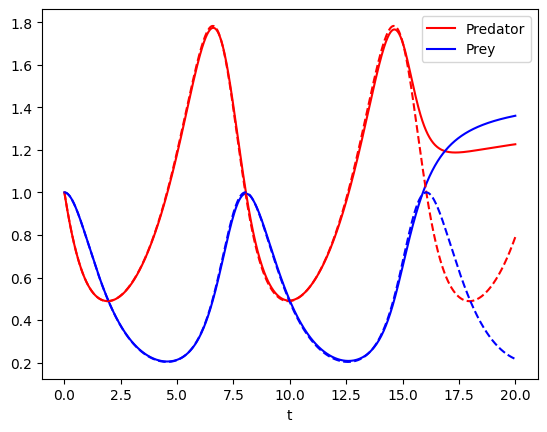

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.17 epoch/s, loss=3.22e-05, bc_loss=9.38e-09, data_loss=0.00e+00, pde_loss=3.22e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 92.38 epoch/s, loss=2.52e-05, bc_loss=8.01e-09, data_loss=0.00e+00, pde_loss=2.52e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 90.84 epoch/s, loss=2.25e-05, bc_loss=6.02e-07, data_loss=0.00e+00, pde_loss=2.19e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 87.63 epoch/s, loss=1.83e-05, bc_loss=5.77e-09, data_loss=0.00e+00, pde_loss=1.83e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 86.67 epoch/s, loss=1.77e-05, bc_loss=1.45e-06, data_loss=0.00e+00, pde_loss=1.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 85.98 epoch/s, loss=1.44e-05, bc_loss=1.64e-08, data_loss=0.00e+00, pde_loss=1.44e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.86 epoch/s, loss=8.29e-05, bc_loss=5.90e-05, data_loss=0.00e+00, pde_loss=2.39e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.51 epoch/s, loss=1.32e-05, bc_loss=9.49e-07, data_loss=0.00e+00, pde_loss=1.23e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 71.90 epoch/s, loss=1.07e-05, bc_loss=1.69e-09, data_loss=0.00e+00, pde_loss=1.07e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 79.08 epoch/s, loss=1.40e-05, bc_loss=2.81e-06, data_loss=0.00e+00, pde_loss=1.12e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 78.71 epoch/s, loss=9.01e-06, bc_loss=1.29e-09, data_loss=0.00e+00, pde_loss=9.00e-06]


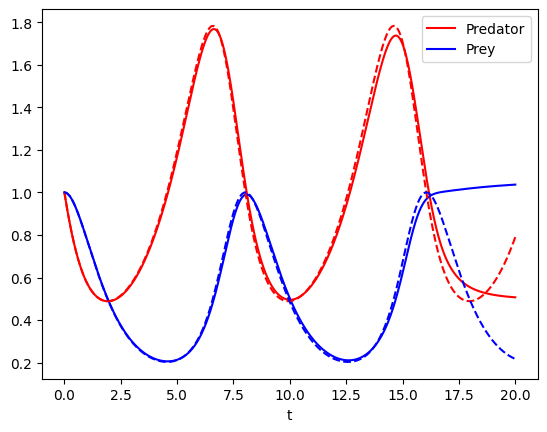

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 93.09 epoch/s, loss=9.90e-05, bc_loss=1.42e-08, data_loss=0.00e+00, pde_loss=9.90e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 92.85 epoch/s, loss=8.08e-05, bc_loss=8.99e-07, data_loss=0.00e+00, pde_loss=7.99e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 90.97 epoch/s, loss=6.92e-05, bc_loss=7.63e-09, data_loss=0.00e+00, pde_loss=6.92e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.77 epoch/s, loss=6.16e-05, bc_loss=1.69e-08, data_loss=0.00e+00, pde_loss=6.16e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.87 epoch/s, loss=5.53e-05, bc_loss=2.39e-08, data_loss=0.00e+00, pde_loss=5.52e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 83.36 epoch/s, loss=5.08e-05, bc_loss=8.95e-07, data_loss=0.00e+00, pde_loss=4.99e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 83.65 epoch/s, loss=4.55e-05, bc_loss=6.88e-08, data_loss=0.00e+00, pde_loss=4.55e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.52 epoch/s, loss=4.16e-05, bc_loss=1.54e-08, data_loss=0.00e+00, pde_loss=4.16e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.65 epoch/s, loss=3.84e-05, bc_loss=6.50e-08, data_loss=0.00e+00, pde_loss=3.84e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 78.05 epoch/s, loss=3.56e-05, bc_loss=1.27e-07, data_loss=0.00e+00, pde_loss=3.55e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 73.83 epoch/s, loss=3.27e-05, bc_loss=1.41e-08, data_loss=0.00e+00, pde_loss=3.27e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 74.91 epoch/s, loss=7.34e-05, bc_loss=2.92e-05, data_loss=0.00e+00, pde_loss=4.42e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 75.34 epoch/s, loss=2.87e-05, bc_loss=4.38e-07, data_loss=0.00e+00, pde_loss=2.82e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 75.05 epoch/s, loss=4.06e-05, bc_loss=1.06e-05, data_loss=0.00e+00, pde_loss=3.00e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 73.15 epoch/s, loss=2.41e-05, bc_loss=4.26e-09, data_loss=0.00e+00, pde_loss=2.41e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 72.53 epoch/s, loss=2.32e-05, bc_loss=5.66e-07, data_loss=0.00e+00, pde_loss=2.26e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 71.92 epoch/s, loss=2.21e-05, bc_loss=1.07e-07, data_loss=0.00e+00, pde_loss=2.20e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 69.05 epoch/s, loss=3.54e-05, bc_loss=4.92e-06, data_loss=0.00e+00, pde_loss=3.05e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 70.13 epoch/s, loss=1.84e-05, bc_loss=8.53e-10, data_loss=0.00e+00, pde_loss=1.84e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 67.26 epoch/s, loss=1.84e-05, bc_loss=2.40e-07, data_loss=0.00e+00, pde_loss=1.82e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.49 epoch/s, loss=1.64e-05, bc_loss=3.37e-08, data_loss=0.00e+00, pde_loss=1.63e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.39 epoch/s, loss=2.10e-05, bc_loss=2.19e-06, data_loss=0.00e+00, pde_loss=1.88e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.01 epoch/s, loss=5.35e-05, bc_loss=3.20e-05, data_loss=0.00e+00, pde_loss=2.15e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 65.43 epoch/s, loss=1.39e-05, bc_loss=1.41e-07, data_loss=0.00e+00, pde_loss=1.38e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 63.86 epoch/s, loss=1.48e-05, bc_loss=1.17e-06, data_loss=0.00e+00, pde_loss=1.36e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 64.13 epoch/s, loss=1.24e-05, bc_loss=1.43e-08, data_loss=0.00e+00, pde_loss=1.24e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 63.20 epoch/s, loss=1.31e-05, bc_loss=8.46e-07, data_loss=0.00e+00, pde_loss=1.23e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 63.24 epoch/s, loss=1.66e-05, bc_loss=4.57e-06, data_loss=0.00e+00, pde_loss=1.20e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 62.50 epoch/s, loss=1.06e-05, bc_loss=2.65e-08, data_loss=0.00e+00, pde_loss=1.06e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 60.72 epoch/s, loss=1.73e-05, bc_loss=6.51e-06, data_loss=0.00e+00, pde_loss=1.08e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:08<00:00, 60.66 epoch/s, loss=9.63e-06, bc_loss=4.48e-09, data_loss=0.00e+00, pde_loss=9.63e-06]


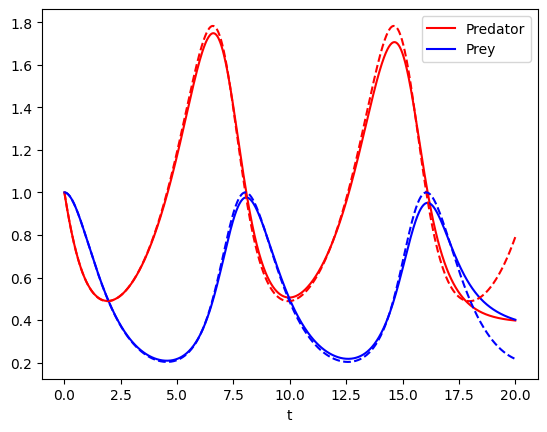

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 92.45 epoch/s, loss=5.76e-05, bc_loss=8.59e-09, data_loss=0.00e+00, pde_loss=5.76e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 92.81 epoch/s, loss=4.82e-05, bc_loss=9.82e-07, data_loss=0.00e+00, pde_loss=4.72e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 90.47 epoch/s, loss=3.93e-05, bc_loss=5.79e-09, data_loss=0.00e+00, pde_loss=3.93e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.84 epoch/s, loss=3.22e-05, bc_loss=1.36e-07, data_loss=0.00e+00, pde_loss=3.21e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 84.10 epoch/s, loss=7.21e-05, bc_loss=3.84e-05, data_loss=0.00e+00, pde_loss=3.37e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.93 epoch/s, loss=2.34e-05, bc_loss=2.48e-06, data_loss=0.00e+00, pde_loss=2.09e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.26 epoch/s, loss=1.75e-05, bc_loss=1.05e-06, data_loss=0.00e+00, pde_loss=1.64e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.97 epoch/s, loss=1.25e-05, bc_loss=1.89e-09, data_loss=0.00e+00, pde_loss=1.25e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.18 epoch/s, loss=9.66e-06, bc_loss=1.05e-08, data_loss=0.00e+00, pde_loss=9.65e-06]


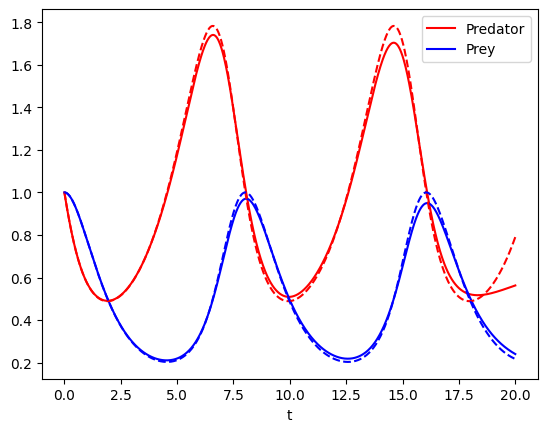

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 93.59 epoch/s, loss=4.29e-05, bc_loss=7.59e-06, data_loss=0.00e+00, pde_loss=3.53e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 93.63 epoch/s, loss=2.34e-05, bc_loss=3.57e-08, data_loss=0.00e+00, pde_loss=2.33e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 88.71 epoch/s, loss=2.17e-05, bc_loss=2.06e-06, data_loss=0.00e+00, pde_loss=1.97e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 89.24 epoch/s, loss=1.52e-05, bc_loss=7.59e-08, data_loss=0.00e+00, pde_loss=1.52e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 87.68 epoch/s, loss=1.32e-05, bc_loss=6.92e-08, data_loss=0.00e+00, pde_loss=1.31e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 82.47 epoch/s, loss=1.12e-05, bc_loss=8.86e-08, data_loss=0.00e+00, pde_loss=1.11e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 83.96 epoch/s, loss=1.08e-05, bc_loss=6.06e-07, data_loss=0.00e+00, pde_loss=1.02e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 81.09 epoch/s, loss=8.40e-06, bc_loss=1.49e-08, data_loss=0.00e+00, pde_loss=8.38e-06]


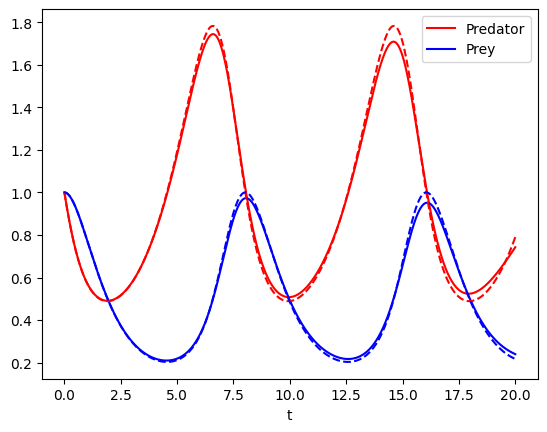

[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 91.22 epoch/s, loss=2.67e-05, bc_loss=3.13e-06, data_loss=0.00e+00, pde_loss=2.35e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:05<00:00, 91.35 epoch/s, loss=2.27e-05, bc_loss=4.67e-06, data_loss=0.00e+00, pde_loss=1.80e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 80.25 epoch/s, loss=1.84e-05, bc_loss=2.47e-06, data_loss=0.00e+00, pde_loss=1.59e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:07<00:00, 66.40 epoch/s, loss=1.03e-05, bc_loss=1.07e-07, data_loss=0.00e+00, pde_loss=1.02e-05]


[Info]: Training 500 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 500/500 [00:06<00:00, 83.18 epoch/s, loss=1.28e-05, bc_loss=2.50e-06, data_loss=0.00e+00, pde_loss=1.03e-05]


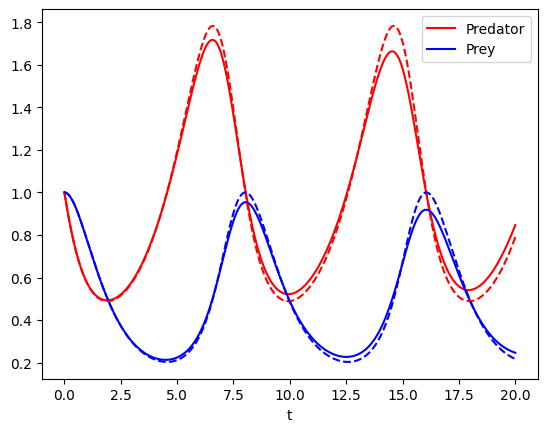

In [74]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-3, weight_decay=1e-4)
upinn.optimizer = adamw

for i in range(time_int[1]):
    upinn.collocation_points = sample_collocation_points(1000, 1, lb=[time_int[0]], ub=[i+1], method='grid').requires_grad_(True)
    loss, _, _, _ = upinn.get_loss()
    while loss.item() > 1e-5:
        upinn.train_loop(500)
        loss, _, _, _ = upinn.get_loss()
    upinn.plot()

In [108]:
upinn.save('lv_pinn_forward', 'models')

[Info]: Successfully saved total model with name lv_pinn_forward at models


In [98]:
adamw = torch.optim.AdamW(upinn.parameters(), lr=1e-5, weight_decay=1e-4)
upinn.optimizer = adamw
upinn.train_loop(5000)

[Info]: Training 5000 epoch(s) on cuda using AdamW optimizer.


[CUDA]: 100%|██████████| 5000/5000 [01:06<00:00, 74.75 epoch/s, loss=3.53e-07, bc_loss=7.97e-10, data_loss=0.00e+00, pde_loss=3.52e-07]


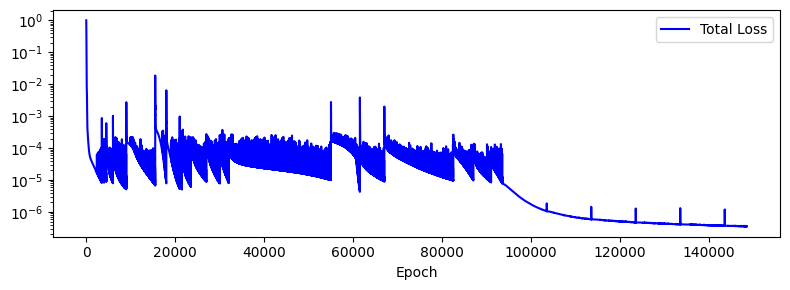

In [107]:
plt.figure( figsize=(8, 3) )
plt.plot(upinn.log['loss'], color='b', label='Total Loss')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('gfx/lv-pinn-loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

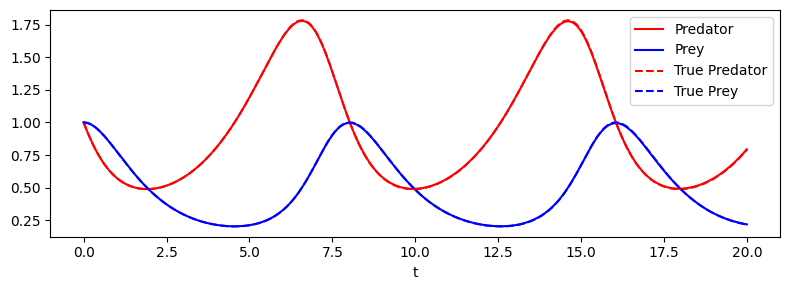

In [106]:
plt.figure( figsize=(8, 3) )

u_pred = upinn.u(data.t_full)

plt.plot(data.t_full, u_pred[:, 0].detach().numpy(), 'r', label='Predator')
plt.plot(data.t_full, u_pred[:, 1].detach().numpy(), 'b', label='Prey')
plt.plot(data.t_full, data.X_full[:, 0].detach().numpy(), 'r--', label='True Predator')
plt.plot(data.t_full, data.X_full[:, 1].detach().numpy(), 'b--', label='True Prey')
plt.xlabel('t')
plt.legend()
plt.tight_layout()
plt.savefig('gfx/lv-pinn-forward.pdf', format='pdf', bbox_inches='tight')
plt.show()

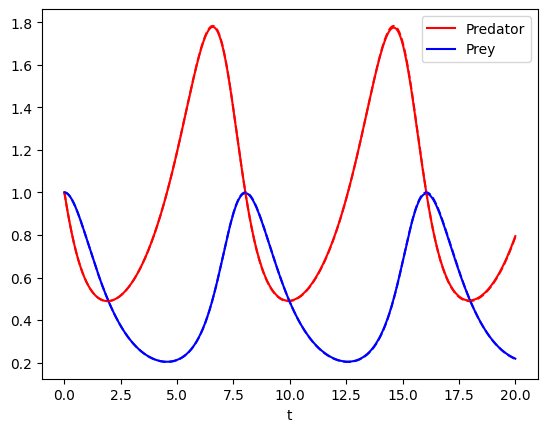

In [91]:
upinn.plot()